# Verification
In the following, the four steps will be performed to make sure the model and its agents
performs all tasks as they are supposed to do.

In [19]:
import pandas as pd

## 1. Recoding and tracking agent behaviour
In the following, one instance of each agent will be initiated. Internal functions
will be tested and it will be insured that they function correctly.

### Households
Importing and initiating an object of the household class.

In [3]:
from Household import Household

Initiation of the model:

In [6]:
household_id = 'H1'
model = None
househould_type = 'one_person'
perception = 0.5
knowledge = 0.6

single_household = Household(household_id, model, househould_type, perception, knowledge)

Print all current attributes

In [7]:
print('ID: {}'.format(single_household.unique_id))
print('Type: {}'.format(single_household.type))
print('Perception: {}'.format(single_household.perception))
print('Knowledge: {}'.format(single_household.knowledge))

ID: M1
Type: one_person
Perception: 0.5
Knowledge: 0.6


The output is as expected. The initialization works.
Now all functions will be executed in the order as they appear in the code.
All function are internal processes.

starting_val calculates the starting value of the base waste. For single households it is
supposed to be 40

In [9]:
single_household.starting_val(single_household.type)

40

Households entailing more people (e.g. families) produce 2.85 times more waste.

In [11]:
family_household = Household(household_id, model, 'multi_person', perception, knowledge)
family_household.starting_val(family_household.type) /40

2.85

Both households produce the right amount of base waste as starting value.
Next the calculation of base waste is tested. The function requires the current tick as input.

In [17]:
single_household.calc_starting_val() # Calculation of starting value
single_household.calc_base_waste(0)
print('Single household base waste: {}'.format(single_household.base_waste))
#
family_household.calc_starting_val()
family_household.calc_base_waste(0)
print('Family household base waste: {}'.format(family_household.base_waste))


Single household base waste: 40.0
Family household base waste: 114.0


The following graph shows the development of the base waste over time.

<AxesSubplot:>

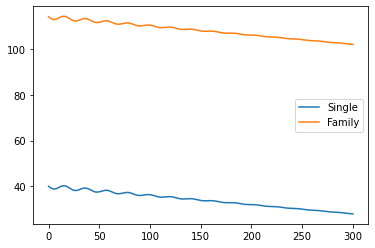

In [21]:
base_waste_df = pd.DataFrame()
base_waste_singel = []
base_waste_family = []
for i in range(301):
    single_household.calc_base_waste(i)
    base_waste_singel.append(single_household.base_waste)

    family_household.calc_base_waste(i)
    base_waste_family.append((family_household.base_waste))

base_waste_df['Single'] = base_waste_singel
base_waste_df['Family'] = base_waste_family

base_waste_df.plot()

The y-axis shows the base waste, the x-axis the ticks. The behavior is as expected.
The calculation of the plastic waste is the product of the base waste, the plastic share in
the base waste ($20\%$) and the individual knowledge and perception. Hence, the expected values are: